In [0]:
!pip install pytrends

In [0]:
import pandas as pd
import numpy as np
import datetime 
import os
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.api as sm

In [0]:
def update_df2(this_df,df):
    '''
    This function aims to merge two time series into one dataframe
    And it also fill missing dates with extra column
    '''
    try:
        df['date']=pd.to_datetime(df['date'], format='%Y-%m-%d')
    except:
        try:
            df['date']=pd.to_datetime(df['date'], format='%d/%m/%Y')
        except:
            df['date']=pd.to_datetime(df['date'])
    df=df.set_index('date')
    df.index = pd.DatetimeIndex(df.index)
    #remove the duplicated index
    df = df[~df.index.duplicated()]
    df = df.reindex(idx)
    try:
        df=df.drop(['_id'], axis=1)     
    except:
        pass
    
    # merge two data 
    if len(this_df)==0:
        if len(df)!=0:
            this_df=df
    else:
        this_df=pd.concat([this_df,df],axis=1)
    return this_df

# setup necessaty parameter


idx = pd.date_range('2005-01-01', '2020-01-31')


def load_daily_index(path = 'merged_data/',file_name='daily_trends.csv',force_update=False,debug=False):
    csv_files  = []
    xlsx_files = []

    def action1(cache=[]):
        for r, d, f in os.walk(path):
            for file in f:
                if '.csv' in file:
                    csv_files.append(os.path.join(r, file))
                if '.xlsx' in file:
                    xlsx_files.append(os.path.join(r, file))
        # concate and merge all the dataframes
        for file in csv_files:
            if debug==True:
                print('\r'+file,end='')
            df=pd.read_csv(file).iloc[:,[0,5]]
            cache = update_df2(cache,df)

        for file in xlsx_files:
            df=pd.read_excel(file).iloc[:,[0,5]]
            cache = update_df2(cache,df)
        # save daily data to one csv
        cache.to_csv('merged_data/'+file_name)
        return cache
    
    if force_update == False:
        try:
            this_df = pd.read_csv('merged_data/'+file_name,index_col=0)
        except:
            this_df = action1()
    else:
        this_df = action1()
    return this_df

In [0]:
# this is the 30 words that is shown by the paper
daily_trends=load_daily_index(force_update=False)
daily_trends.index = pd.DatetimeIndex(daily_trends.index)

In [0]:
daily_trends = daily_trends.replace({0:1})  # replace 0 search with 1 to avoid problem
return_ratio = np.log(daily_trends.iloc[1:,:])-np.log(daily_trends.iloc[:-1,:].values)
for column in list(return_ratio):   
    return_ratio.loc[:,column] = scipy.stats.mstats.winsorize(return_ratio.loc[:,column].values, limits=[0.05, 0.05])

### Now remove the seasonality

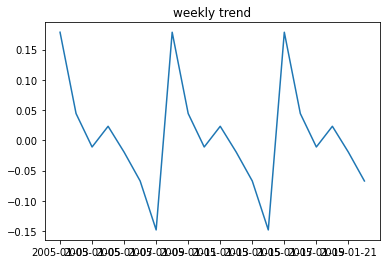

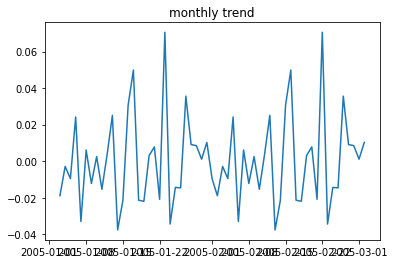

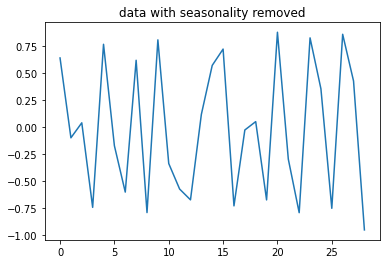

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

data = return_ratio.loc[:,'PRICE OF GOLD']
weekly = seasonal_decompose(data, freq=7)
plt.plot(weekly.seasonal[1:21])
plt.title('weekly trend')
plt.show()
data = data - weekly.seasonal
monthly = seasonal_decompose(data, freq=30)
data = data - monthly.seasonal


plt.plot(monthly.seasonal[1:60])
plt.title('monthly trend')
plt.show()

plt.plot(data.values[1:30])
plt.title('data with seasonality removed')
plt.show()



def remove_seasonality(data):
    weekly = seasonal_decompose(data, freq=7)
    r = data - weekly.seasonal
    monthly = seasonal_decompose(r, freq=30)
    r = r - monthly.seasonal
    return r

# remove seasonality on weekly and monthly dummy, and standardized by scaling each on standard deviation
original_return = return_ratio.copy()
for column in list(return_ratio):   
    return_ratio.loc[:,column] = remove_seasonality(return_ratio.loc[:,column])
    return_ratio.loc[:,column] /= np.std(return_ratio.loc[:,column].values)

In [0]:
return_ratio['fears_index'] = return_ratio.sum(axis=1)/30
original_return['fears_index'] = original_return.sum(axis=1)/30

In [0]:
SPY=pd.read_csv('merged_data/SPY.csv').iloc[:,[0,4]]
SPY['Date']=pd.to_datetime(SPY['Date'], format='%Y-%m-%d')
SPY=SPY.set_index('Date')
SPY.columns=['SPY']
SPY = np.log(SPY.iloc[1:,:])-np.log(SPY.iloc[:-1,:].values)

IWB=pd.read_csv('merged_data/IWB.csv').iloc[:,[0,4]]
IWB['Date']=pd.to_datetime(IWB['Date'], format='%Y-%m-%d')
IWB=IWB.set_index('Date')
IWB.columns=['IWB']
IWB = np.log(IWB.iloc[1:,:])-np.log(IWB.iloc[:-1,:].values)

IWM=pd.read_csv('merged_data/IWM.csv').iloc[:,[0,4]]
IWM['Date']=pd.to_datetime(IWM['Date'], format='%Y-%m-%d')
IWM=IWM.set_index('Date')
IWM.columns=['IWM']
IWM = np.log(IWM.iloc[1:,:])-np.log(IWM.iloc[:-1,:].values)


In [0]:
EPU=pd.read_excel('merged_data/All_Daily_Policy_Data.xlsx')
EPU['Date']=pd.to_datetime(EPU['Date'], format='%d/%m/%Y')
EPU = EPU.set_index('Date')
EPU.columns=['EPU']
EPU = np.log(EPU.iloc[1:,:])-np.log(EPU.iloc[:-1,:].values)

ADS=pd.read_excel('merged_data/ADS_Index_Most_Current_Vintage.xlsx',index_col=0)
ADS.columns=['ADS']
ADS = (ADS.iloc[1:,:]-ADS.iloc[:-1,:].values).divide(ADS.iloc[:-1,:].values)

VIX = pd.read_csv('merged_data/vixcurrent.csv').iloc[:,[0,4]]
VIX['Date']=pd.to_datetime(VIX['Date'], format='%m/%d/%Y')
VIX = VIX.set_index('Date')
VIX.columns=['VIX']
VIX = np.log(VIX.iloc[1:,:])-np.log(VIX.iloc[:-1,:].values)

In [0]:
# first read the data
all_daily_trends = load_daily_index(path = '111_google_trend/',file_name='111_daily_trends.csv', force_update=False,debug=True)
all_daily_trends = all_daily_trends.loc[:,(all_daily_trends.isna().sum()<100).values]  # remove column with too many missing value

In [0]:
all_daily_trends = all_daily_trends.replace({0:1})  # replace 0 search with 1 to avoid problem
all_return_ratio = np.log(all_daily_trends.iloc[1:,:])-np.log(all_daily_trends.iloc[:-1,:].values)

for column in list(all_return_ratio):              
    # winsorize data
    all_return_ratio.loc[:,column] = scipy.stats.mstats.winsorize(all_return_ratio.loc[:,column].values, limits=[0.05, 0.05])
    # remove seasonality
    all_return_ratio.loc[:,column] = remove_seasonality(all_return_ratio.loc[:,column])
    # removeheteroscedasticity
    all_return_ratio.loc[:,column] /= np.std(all_return_ratio.loc[:,column].values)
all_return_ratio.index = pd.DatetimeIndex(all_return_ratio.index)

In [0]:
def create_dynamic_index_SPY(frequency,all_return_ratio,SPY):
    all_return_with_Fears = all_return_ratio.copy()
    start_date = pd.Timestamp(year=2005, month=1, day=2).date()
    end_date = start_date + pd.Timedelta(frequency*30,unit='D')
    next_end_date = end_date + pd.Timedelta(frequency*30,unit='D')


    while next_end_date<pd.Timestamp(year=2020, month=1, day=30).date():
        print('\r now end time is '+str(end_date),end='')
        # seperate the dataset into several time segements 
        selected_data = all_return_ratio.loc[pd.date_range(start_date,end_date),:]

        # includes return data
        word_choices = list(selected_data)
        selected_data_SPY = selected_data.join(SPY,how='inner')
        ranking = []

        # run regression on all 104 words within this selected periods
        for word in word_choices:
            X = sm.add_constant(selected_data_SPY.loc[:,[word]])
            model = sm.OLS(selected_data_SPY.loc[:,['SPY']], X).fit()   # run regression
            t_stats = pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0]['t'][1]
            ranking.append([t_stats,word])    # save word and t statistics

        # select the 30 most negative words
        ranking.sort()
        negative_30_words = [ranking[i][1] for i in range(30)] 
        this_fears_index = selected_data.loc[:,negative_30_words].sum(axis=1)/30

        # update the fears index
        all_return_with_Fears.loc[(all_return_with_Fears.index>=pd.Timestamp(end_date)) & (all_return_with_Fears.index<=pd.Timestamp(next_end_date)),'FEARS'] = this_fears_index.values
        start_date = end_date
        end_date = next_end_date
        next_end_date = next_end_date + pd.Timedelta(frequency*30,unit='D')
    Fears_index = all_return_with_Fears.loc[all_return_with_Fears.FEARS.isna()!=True,['FEARS']]
    return Fears_index

In [0]:
def create_dynamic_index_IWB(frequency,all_return_ratio,IWB):
    all_return_with_Fears = all_return_ratio.copy()
    start_date = pd.Timestamp(year=2005, month=1, day=2).date()
    end_date = start_date + pd.Timedelta(frequency*30,unit='D')
    next_end_date = end_date + pd.Timedelta(frequency*30,unit='D')


    while next_end_date<pd.Timestamp(year=2020, month=1, day=30).date():
        print('\r now end time is '+str(end_date),end='')
        # seperate the dataset into several time segements 
        selected_data = all_return_ratio.loc[pd.date_range(start_date,end_date),:]

        # includes return data
        word_choices = list(selected_data)
        selected_data_IWB = selected_data.join(IWB,how='inner')
        ranking = []

        # run regression on all 104 words within this selected periods
        for word in word_choices:
            X = sm.add_constant(selected_data_IWB.loc[:,[word]])
            model = sm.OLS(selected_data_IWB.loc[:,['IWB']], X).fit()   # run regression
            t_stats = pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0]['t'][1]
            ranking.append([t_stats,word])    # save word and t statistics

        # select the 30 most negative words
        ranking.sort()
        negative_30_words = [ranking[i][1] for i in range(30)] 
        this_fears_index = selected_data.loc[:,negative_30_words].sum(axis=1)/30

        # update the fears index
        all_return_with_Fears.loc[(all_return_with_Fears.index>=pd.Timestamp(end_date)) & (all_return_with_Fears.index<=pd.Timestamp(next_end_date)),'FEARS'] = this_fears_index.values
        start_date = end_date
        end_date = next_end_date
        next_end_date = next_end_date + pd.Timedelta(frequency*30,unit='D')
    Fears_index = all_return_with_Fears.loc[all_return_with_Fears.FEARS.isna()!=True,['FEARS']]
    return Fears_index

In [0]:
def create_dynamic_index_IWM(frequency,all_return_ratio,IWM):
    all_return_with_Fears = all_return_ratio.copy()
    start_date = pd.Timestamp(year=2005, month=1, day=2).date()
    end_date = start_date + pd.Timedelta(frequency*30,unit='D')
    next_end_date = end_date + pd.Timedelta(frequency*30,unit='D')


    while next_end_date<pd.Timestamp(year=2020, month=1, day=30).date():
        print('\r now end time is '+str(end_date),end='')
        # seperate the dataset into several time segements 
        selected_data = all_return_ratio.loc[pd.date_range(start_date,end_date),:]

        # includes return data
        word_choices = list(selected_data)
        selected_data_IWM = selected_data.join(IWM,how='inner')
        ranking = []

        # run regression on all 104 words within this selected periods
        for word in word_choices:
            X = sm.add_constant(selected_data_IWM.loc[:,[word]])
            model = sm.OLS(selected_data_IWM.loc[:,['IWM']], X).fit()   # run regression
            t_stats = pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0]['t'][1]
            ranking.append([t_stats,word])    # save word and t statistics

        # select the 30 most negative words
        ranking.sort()
        negative_30_words = [ranking[i][1] for i in range(30)] 
        this_fears_index = selected_data.loc[:,negative_30_words].sum(axis=1)/30

        # update the fears index
        all_return_with_Fears.loc[(all_return_with_Fears.index>=pd.Timestamp(end_date)) & (all_return_with_Fears.index<=pd.Timestamp(next_end_date)),'FEARS'] = this_fears_index.values
        start_date = end_date
        end_date = next_end_date
        next_end_date = next_end_date + pd.Timedelta(frequency*30,unit='D')
    Fears_index = all_return_with_Fears.loc[all_return_with_Fears.FEARS.isna()!=True,['FEARS']]
    return Fears_index

In [16]:
Fears_index_SPY = create_dynamic_index_SPY(6, all_return_ratio,SPY)

 now end time is 2019-04-19

In [17]:
Fears_index_IWB = create_dynamic_index_IWB(6, all_return_ratio,IWB)

 now end time is 2019-04-19

In [18]:
Fears_index_IWM = create_dynamic_index_IWM(6, all_return_ratio,IWM)

 now end time is 2019-04-19

## SPY

In [19]:
merged_data= SPY.join(EPU,how='inner')
merged_data= merged_data.join(ADS,how='inner')
merged_data= merged_data.join(VIX,how='inner')
merged_data= merged_data.join(return_ratio.fears_index,how='inner')
merged_data= merged_data.join(Fears_index_SPY,how='inner').rename(columns={'fears_index':'static_fears','FEARS':'6month_dynamic_fears'})
merged_data.head()
merged_data.to_csv('merged_data/final_data.csv')
print(len(merged_data))

3598


In [20]:
start = 0
end = 3200-5
trained_data = merged_data.iloc[(start+5):end,[0,1,2,3,5]].copy() 

trained_data.loc[:,'t-1'] = merged_data.iloc[(start+4):(end-1),0].values
trained_data.loc[:,'t-2'] = merged_data.iloc[(start+3):(end-2),0].values
trained_data.loc[:,'t-3'] = merged_data.iloc[(start+2):(end-3),0].values
trained_data.loc[:,'t-4'] = merged_data.iloc[(start+1):(end-4),0].values
trained_data.loc[:,'t-5'] = merged_data.iloc[start:(end-5),0].values

X = sm.add_constant(trained_data.iloc[:,1:])
model = sm.OLS(merged_data.iloc[(start+5):(end),0].values, X).fit()
print('Ret(t)')
print(pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0].loc[:,['coef','t','P>|t|']])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[5],[0,1]])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[1],[2,3]])

Ret(t)
                        coef       t  P>|t|
const                 0.0003   1.872  0.061
EPU                  -0.0003  -0.960  0.337
ADS                  -0.0003  -1.305  0.192
VIX                  -0.1193 -61.137  0.000
6month_dynamic_fears -0.0002  -0.276  0.782
t-1                  -0.0129  -1.066  0.287
t-2                  -0.0313  -2.587  0.010
t-3                   0.0469   3.871  0.000
t-4                  -0.0012  -0.101  0.920
t-5                  -0.0271  -2.256  0.024
                   0     1
5  No. Observations:  3190
                 2      3
1  Adj. R-squared:  0.547


In [21]:
trained_data = merged_data.iloc[(start+5):end,[0,1,2,3,5]].copy() 

trained_data.loc[:,'t'] = merged_data.iloc[(start+5):end,0].values
trained_data.loc[:,'t-1'] = merged_data.iloc[(start+4):(end-1),0].values
trained_data.loc[:,'t-2'] = merged_data.iloc[(start+3):(end-2),0].values
trained_data.loc[:,'t-3'] = merged_data.iloc[(start+2):(end-3),0].values
trained_data.loc[:,'t-4'] = merged_data.iloc[(start+1):(end-4),0].values
trained_data.loc[:,'t-5'] = merged_data.iloc[start:(end-5),0].values

X = sm.add_constant(trained_data.iloc[:,1:])
model = sm.OLS(merged_data.iloc[(start+6):(end+1),0].values, X).fit()

print('Ret(t+1)')
print(pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0].loc[:,['coef','t','P>|t|']])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[5],[0,1]])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[1],[2,3]])

Ret(t+1)
                         coef      t  P>|t|
const                 0.00030  1.308  0.191
EPU                  -0.00050 -1.338  0.181
ADS                   0.00004  0.128  0.898
VIX                  -0.00220 -0.513  0.608
6month_dynamic_fears  0.00110  1.416  0.157
t                    -0.09370 -3.582  0.000
t-1                  -0.08500 -4.776  0.000
t-2                   0.01280  0.718  0.473
t-3                  -0.01570 -0.876  0.381
t-4                  -0.04990 -2.810  0.005
t-5                   0.00420  0.236  0.814
                   0     1
5  No. Observations:  3190
                 2      3
1  Adj. R-squared:  0.015


In [22]:
trained_data = merged_data.iloc[(start+5):end,[0,1,2,3,5]].copy() 
trained_data.loc[:,'t'] = merged_data.iloc[(start+5):end,0].values
trained_data.loc[:,'t-1'] = merged_data.iloc[(start+4):(end-1),0].values
trained_data.loc[:,'t-2'] = merged_data.iloc[(start+3):(end-2),0].values
trained_data.loc[:,'t-3'] = merged_data.iloc[(start+2):(end-3),0].values
trained_data.loc[:,'t-4'] = merged_data.iloc[(start+1):(end-4),0].values
trained_data.loc[:,'t-5'] = merged_data.iloc[start:(end-5),0].values

X = sm.add_constant(trained_data.iloc[:,1:])
model = sm.OLS(merged_data.iloc[(start+7):(end+2),0].values, X).fit()

print('Ret(t+2)')
print(pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0].loc[:,['coef','t','P>|t|']])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[5],[0,1]])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[1],[2,3]])

Ret(t+2)
                        coef      t  P>|t|
const                 0.0003  1.599  0.110
EPU                   0.0007  1.823  0.068
ADS                   0.0003  0.913  0.361
VIX                  -0.0091 -2.147  0.032
6month_dynamic_fears -0.0009 -1.063  0.288
t                    -0.1197 -4.564  0.000
t-1                   0.0232  1.300  0.194
t-2                  -0.0172 -0.963  0.335
t-3                  -0.0479 -2.671  0.008
t-4                   0.0079  0.445  0.656
t-5                  -0.0161 -0.906  0.365
                   0     1
5  No. Observations:  3190
                 2     3
1  Adj. R-squared:  0.01


In [23]:
trained_data = merged_data.iloc[(start+5):end,[0,1,2,3,5]].copy() 
trained_data.loc[:,'t'] = merged_data.iloc[(start+5):end,0].values
trained_data.loc[:,'t-1'] = merged_data.iloc[(start+4):(end-1),0].values
trained_data.loc[:,'t-2'] = merged_data.iloc[(start+3):(end-2),0].values
trained_data.loc[:,'t-3'] = merged_data.iloc[(start+2):(end-3),0].values
trained_data.loc[:,'t-4'] = merged_data.iloc[(start+1):(end-4),0].values
trained_data.loc[:,'t-5'] = merged_data.iloc[start:(end-5),0].values

X = sm.add_constant(trained_data.iloc[:,1:])
model = sm.OLS(merged_data.iloc[(start+8):(end+3),0].values, X).fit()

print('Ret(t+3)')
print(pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0].loc[:,['coef','t','P>|t|']])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[5],[0,1]])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[1],[2,3]])

Ret(t+3)
                          coef      t  P>|t|
const                 0.000300  1.235  0.217
EPU                   0.000300  0.695  0.487
ADS                   0.000074  0.237  0.813
VIX                   0.002400  0.552  0.581
6month_dynamic_fears  0.000800  0.925  0.355
t                     0.038800  1.472  0.141
t-1                  -0.012200 -0.681  0.496
t-2                  -0.051100 -2.847  0.004
t-3                   0.009700  0.536  0.592
t-4                  -0.010500 -0.585  0.559
t-5                   0.017100  0.958  0.338
                   0     1
5  No. Observations:  3190
                 2      3
1  Adj. R-squared:  0.002


#IWM

In [24]:
merged_data= IWM.join(EPU,how='inner')
merged_data= merged_data.join(ADS,how='inner')
merged_data= merged_data.join(VIX,how='inner')
merged_data= merged_data.join(return_ratio.fears_index,how='inner')
merged_data= merged_data.join(Fears_index_IWB,how='inner').rename(columns={'fears_index':'static_fears','FEARS':'6month_dynamic_fears'})
merged_data.head()
merged_data.to_csv('merged_data/final_data.csv')
print(len(merged_data))

3598


In [25]:
start = 0
end = 3200-5
trained_data = merged_data.iloc[(start+5):end,[0,1,2,3,5]].copy() 

trained_data.loc[:,'t-1'] = merged_data.iloc[(start+4):(end-1),0].values
trained_data.loc[:,'t-2'] = merged_data.iloc[(start+3):(end-2),0].values
trained_data.loc[:,'t-3'] = merged_data.iloc[(start+2):(end-3),0].values
trained_data.loc[:,'t-4'] = merged_data.iloc[(start+1):(end-4),0].values
trained_data.loc[:,'t-5'] = merged_data.iloc[start:(end-5),0].values

X = sm.add_constant(trained_data.iloc[:,1:])
model = sm.OLS(merged_data.iloc[(start+5):(end),0].values, X).fit()
print('Ret(t)')
print(pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0].loc[:,['coef','t','P>|t|']])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[5],[0,1]])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[1],[2,3]])

Ret(t)
                          coef       t  P>|t|
const                 0.000300   1.585  0.113
EPU                   0.000052   0.140  0.889
ADS                  -0.000300  -1.060  0.289
VIX                  -0.142500 -54.188  0.000
6month_dynamic_fears -0.000600  -0.871  0.384
t-1                  -0.012800  -0.999  0.318
t-2                   0.014200   1.110  0.267
t-3                   0.026900   2.102  0.036
t-4                  -0.019900  -1.558  0.119
t-5                  -0.027500  -2.152  0.031
                   0     1
5  No. Observations:  3190
                 2      3
1  Adj. R-squared:  0.485


In [26]:
trained_data = merged_data.iloc[(start+5):end,[0,1,2,3,5]].copy() 

trained_data.loc[:,'t'] = merged_data.iloc[(start+5):end,0].values
trained_data.loc[:,'t-1'] = merged_data.iloc[(start+4):(end-1),0].values
trained_data.loc[:,'t-2'] = merged_data.iloc[(start+3):(end-2),0].values
trained_data.loc[:,'t-3'] = merged_data.iloc[(start+2):(end-3),0].values
trained_data.loc[:,'t-4'] = merged_data.iloc[(start+1):(end-4),0].values
trained_data.loc[:,'t-5'] = merged_data.iloc[start:(end-5),0].values

X = sm.add_constant(trained_data.iloc[:,1:])
model = sm.OLS(merged_data.iloc[(start+6):(end+1),0].values, X).fit()

print('Ret(t+1)')
print(pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0].loc[:,['coef','t','P>|t|']])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[5],[0,1]])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[1],[2,3]])

Ret(t+1)
                        coef      t  P>|t|
const                 0.0003  1.054  0.292
EPU                  -0.0005 -0.914  0.361
ADS                   0.0002  0.413  0.680
VIX                  -0.0034 -0.680  0.497
6month_dynamic_fears  0.0013  1.255  0.210
t                    -0.0858 -3.488  0.000
t-1                  -0.0242 -1.359  0.174
t-2                   0.0018  0.099  0.921
t-3                  -0.0354 -1.992  0.046
t-4                  -0.0570 -3.214  0.001
t-5                   0.0123  0.695  0.487
                   0     1
5  No. Observations:  3190
                 2      3
1  Adj. R-squared:  0.008


In [27]:
trained_data = merged_data.iloc[(start+5):end,[0,1,2,3,5]].copy() 
trained_data.loc[:,'t'] = merged_data.iloc[(start+5):end,0].values
trained_data.loc[:,'t-1'] = merged_data.iloc[(start+4):(end-1),0].values
trained_data.loc[:,'t-2'] = merged_data.iloc[(start+3):(end-2),0].values
trained_data.loc[:,'t-3'] = merged_data.iloc[(start+2):(end-3),0].values
trained_data.loc[:,'t-4'] = merged_data.iloc[(start+1):(end-4),0].values
trained_data.loc[:,'t-5'] = merged_data.iloc[start:(end-5),0].values

X = sm.add_constant(trained_data.iloc[:,1:])
model = sm.OLS(merged_data.iloc[(start+7):(end+2),0].values, X).fit()

print('Ret(t+2)')
print(pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0].loc[:,['coef','t','P>|t|']])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[5],[0,1]])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[1],[2,3]])

Ret(t+2)
                        coef      t  P>|t|
const                 0.0003  1.288  0.198
EPU                   0.0010  1.874  0.061
ADS                   0.0005  1.352  0.176
VIX                   0.0018  0.346  0.730
6month_dynamic_fears -0.0011 -1.084  0.278
t                    -0.0132 -0.536  0.592
t-1                   0.0048  0.268  0.789
t-2                  -0.0359 -2.017  0.044
t-3                  -0.0554 -3.108  0.002
t-4                   0.0162  0.911  0.363
t-5                  -0.0057 -0.321  0.748
                   0     1
5  No. Observations:  3190
                 2      3
1  Adj. R-squared:  0.004


In [28]:
trained_data = merged_data.iloc[(start+5):end,[0,1,2,3,5]].copy() 
trained_data.loc[:,'t'] = merged_data.iloc[(start+5):end,0].values
trained_data.loc[:,'t-1'] = merged_data.iloc[(start+4):(end-1),0].values
trained_data.loc[:,'t-2'] = merged_data.iloc[(start+3):(end-2),0].values
trained_data.loc[:,'t-3'] = merged_data.iloc[(start+2):(end-3),0].values
trained_data.loc[:,'t-4'] = merged_data.iloc[(start+1):(end-4),0].values
trained_data.loc[:,'t-5'] = merged_data.iloc[start:(end-5),0].values

X = sm.add_constant(trained_data.iloc[:,1:])
model = sm.OLS(merged_data.iloc[(start+8):(end+3),0].values, X).fit()

print('Ret(t+3)')
print(pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0].loc[:,['coef','t','P>|t|']])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[5],[0,1]])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[1],[2,3]])

Ret(t+3)
                          coef      t  P>|t|
const                 0.000300  1.085  0.278
EPU                   0.000100  0.202  0.840
ADS                   0.000100  0.381  0.703
VIX                  -0.004500 -0.877  0.381
6month_dynamic_fears  0.000041  0.040  0.968
t                    -0.009200 -0.374  0.709
t-1                  -0.035700 -2.004  0.045
t-2                  -0.053300 -2.987  0.003
t-3                   0.017700  0.993  0.321
t-4                  -0.003900 -0.218  0.827
t-5                   0.009900  0.559  0.576
                   0     1
5  No. Observations:  3190
                 2      3
1  Adj. R-squared:  0.002


#IWB

In [29]:
merged_data= IWB.join(EPU,how='inner')
merged_data= merged_data.join(ADS,how='inner')
merged_data= merged_data.join(VIX,how='inner')
merged_data= merged_data.join(return_ratio.fears_index,how='inner')
merged_data= merged_data.join(Fears_index_IWB,how='inner').rename(columns={'fears_index':'static_fears','FEARS':'6month_dynamic_fears'})
merged_data.head()
merged_data.to_csv('merged_data/final_data.csv')
print(len(merged_data))

3598


In [30]:
start = 0
end = 3200-5
trained_data = merged_data.iloc[(start+5):end,[0,1,2,3,5]].copy() 

trained_data.loc[:,'t-1'] = merged_data.iloc[(start+4):(end-1),0].values
trained_data.loc[:,'t-2'] = merged_data.iloc[(start+3):(end-2),0].values
trained_data.loc[:,'t-3'] = merged_data.iloc[(start+2):(end-3),0].values
trained_data.loc[:,'t-4'] = merged_data.iloc[(start+1):(end-4),0].values
trained_data.loc[:,'t-5'] = merged_data.iloc[start:(end-5),0].values

X = sm.add_constant(trained_data.iloc[:,1:])
model = sm.OLS(merged_data.iloc[(start+5):(end),0].values, X).fit()
print('Ret(t)')
print(pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0].loc[:,['coef','t','P>|t|']])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[5],[0,1]])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[1],[2,3]])

Ret(t)
                        coef       t  P>|t|
const                 0.0003   1.946  0.052
EPU                  -0.0002  -0.747  0.455
ADS                  -0.0003  -1.314  0.189
VIX                  -0.1187 -62.029  0.000
6month_dynamic_fears -0.0003  -0.490  0.624
t-1                  -0.0073  -0.612  0.541
t-2                  -0.0118  -0.985  0.325
t-3                   0.0543   4.535  0.000
t-4                  -0.0126  -1.058  0.290
t-5                  -0.0212  -1.778  0.075
                   0     1
5  No. Observations:  3190
                 2      3
1  Adj. R-squared:  0.553


In [31]:
trained_data = merged_data.iloc[(start+5):end,[0,1,2,3,5]].copy() 

trained_data.loc[:,'t'] = merged_data.iloc[(start+5):end,0].values
trained_data.loc[:,'t-1'] = merged_data.iloc[(start+4):(end-1),0].values
trained_data.loc[:,'t-2'] = merged_data.iloc[(start+3):(end-2),0].values
trained_data.loc[:,'t-3'] = merged_data.iloc[(start+2):(end-3),0].values
trained_data.loc[:,'t-4'] = merged_data.iloc[(start+1):(end-4),0].values
trained_data.loc[:,'t-5'] = merged_data.iloc[start:(end-5),0].values

X = sm.add_constant(trained_data.iloc[:,1:])
model = sm.OLS(merged_data.iloc[(start+6):(end+1),0].values, X).fit()

print('Ret(t+1)')
print(pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0].loc[:,['coef','t','P>|t|']])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[5],[0,1]])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[1],[2,3]])

Ret(t+1)
                          coef      t  P>|t|
const                 0.000300  1.375  0.169
EPU                  -0.000400 -1.019  0.308
ADS                   0.000051  0.168  0.867
VIX                  -0.003000 -0.701  0.483
6month_dynamic_fears  0.000900  1.175  0.240
t                    -0.089200 -3.381  0.001
t-1                  -0.060700 -3.411  0.001
t-2                   0.023700  1.332  0.183
t-3                  -0.027300 -1.528  0.127
t-4                  -0.048100 -2.710  0.007
t-5                  -0.003300 -0.184  0.854
                   0     1
5  No. Observations:  3190
                 2      3
1  Adj. R-squared:  0.011


In [32]:
trained_data = merged_data.iloc[(start+5):end,[0,1,2,3,5]].copy() 
trained_data.loc[:,'t'] = merged_data.iloc[(start+5):end,0].values
trained_data.loc[:,'t-1'] = merged_data.iloc[(start+4):(end-1),0].values
trained_data.loc[:,'t-2'] = merged_data.iloc[(start+3):(end-2),0].values
trained_data.loc[:,'t-3'] = merged_data.iloc[(start+2):(end-3),0].values
trained_data.loc[:,'t-4'] = merged_data.iloc[(start+1):(end-4),0].values
trained_data.loc[:,'t-5'] = merged_data.iloc[start:(end-5),0].values

X = sm.add_constant(trained_data.iloc[:,1:])
model = sm.OLS(merged_data.iloc[(start+7):(end+2),0].values, X).fit()

print('Ret(t+2)')
print(pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0].loc[:,['coef','t','P>|t|']])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[5],[0,1]])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[1],[2,3]])

Ret(t+2)
                        coef      t  P>|t|
const                 0.0003  1.624  0.104
EPU                   0.0007  1.823  0.068
ADS                   0.0003  0.990  0.322
VIX                  -0.0051 -1.212  0.225
6month_dynamic_fears -0.0009 -1.131  0.258
t                    -0.0795 -3.007  0.003
t-1                   0.0306  1.718  0.086
t-2                  -0.0291 -1.629  0.103
t-3                  -0.0460 -2.567  0.010
t-4                  -0.0005 -0.027  0.979
t-5                  -0.0142 -0.798  0.425
                   0     1
5  No. Observations:  3190
                 2      3
1  Adj. R-squared:  0.007


In [33]:
trained_data = merged_data.iloc[(start+5):end,[0,1,2,3,5]].copy() 
trained_data.loc[:,'t'] = merged_data.iloc[(start+5):end,0].values
trained_data.loc[:,'t-1'] = merged_data.iloc[(start+4):(end-1),0].values
trained_data.loc[:,'t-2'] = merged_data.iloc[(start+3):(end-2),0].values
trained_data.loc[:,'t-3'] = merged_data.iloc[(start+2):(end-3),0].values
trained_data.loc[:,'t-4'] = merged_data.iloc[(start+1):(end-4),0].values
trained_data.loc[:,'t-5'] = merged_data.iloc[start:(end-5),0].values

X = sm.add_constant(trained_data.iloc[:,1:])
model = sm.OLS(merged_data.iloc[(start+8):(end+3),0].values, X).fit()

print('Ret(t+3)')
print(pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0].loc[:,['coef','t','P>|t|']])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[5],[0,1]])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[1],[2,3]])

Ret(t+3)
                        coef      t  P>|t|
const                 0.0003  1.305  0.192
EPU                   0.0002  0.574  0.566
ADS                   0.0001  0.346  0.729
VIX                   0.0034  0.793  0.428
6month_dynamic_fears  0.0004  0.510  0.610
t                     0.0489  1.846  0.065
t-1                  -0.0279 -1.560  0.119
t-2                  -0.0487 -2.721  0.007
t-3                   0.0005  0.030  0.976
t-4                  -0.0107 -0.598  0.550
t-5                   0.0123  0.689  0.491
                   0     1
5  No. Observations:  3190
                 2      3
1  Adj. R-squared:  0.002
